<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Восстановление золота из руды

Подготовим прототип модели машинного обучения для компании, разрабатывающей решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используем данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Необходимо:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Для начала получим некоторые общие представления о той задаче, которую предстоит решить. Итак, необходимо построить модель, предсказывающую коэффициент восстановления золота из руды и помогающую бизнесу не запускать убыточное производство. Это задача регрессии. 

В связи с особенностями добычи золотосодержащей руды, необходимо будет спрогнозировать сразу два коэффициента: коэффициент обогащения чернового и финального концентрата. 

## Подготовка данных

Для начала импортируем все необходимые для работы инструменты и библиотеки.

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (15,13)
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

Загрузим все данные и изучим их.

In [2]:
gold_industry_train = pd.read_csv('/datasets/gold_industry_train.csv')
gold_industry_test = pd.read_csv('/datasets/gold_industry_test.csv')
gold_industry_full = pd.read_csv('/datasets/gold_industry_full.csv')

In [3]:
gold_industry_train.info()
gold_industry_test.info()
gold_industry_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


In [4]:
print(f'''Количество столбцов обучающей выборки: {len(gold_industry_train.columns)}
Количество столбцов тестовой выборки {len(gold_industry_test.columns)}
Количество столбцов полных данных  {len(gold_industry_full.columns)}''')

Количество столбцов обучающей выборки: 87
Количество столбцов тестовой выборки 53
Количество столбцов полных данных  87


In [5]:
sum(gold_industry_train.columns == gold_industry_full.columns)

87

При беглом обзоре видно, что в данных присутствуют пропуски. Кроме того, в тестовой выборке меньше столбцов, чем в обучающей. Все данные, кроме столбца с датой - вещественные числа.

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдём MAE между нашими расчётами и значением признака. 

In [6]:
check = (
    (gold_industry_train['rougher.output.concentrate_au']*(gold_industry_train['rougher.input.feed_au']-gold_industry_train['rougher.output.tail_au']))/
    (gold_industry_train['rougher.input.feed_au']*(gold_industry_train['rougher.output.concentrate_au']-gold_industry_train['rougher.output.tail_au']))
)*100
check

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14574    87.684717
14575    90.677361
14576    89.574376
14577    87.724007
14578    88.890579
Length: 14579, dtype: float64

In [7]:
mae = mean_absolute_error(check, gold_industry_train['rougher.output.recovery'] )
mae

9.83758577644259e-15

Итак, recovery была вычислена вручную, а затем было произведено сравнение вычисленной recovery с представленной в данных по МАЕ. МАЕ крайне мала (10^-15), поэтому можно сделать вывод, что в обучающей выборке она предсказана точно.

Теперь проанализируем признаки, недоступные в тестовой выборке.

In [8]:
features_not_in_test = [feature for feature in list(gold_industry_train.columns) if feature not in list(gold_industry_test.columns)]
features_not_in_test

['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'secondary_cleaner.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol',
 'final.output.concentrate_au',
 'final.output.concentrate_ag',
 'final

Видим, что признаки, отсутствующие тестовой выборке относятся ко всему тому, что происходит после этапов флотации или очистки. То есть результатов проведения этих процессов в тестовой выборке нет. Также видим, что в тестовой выборки нет данных таргета rougher.output.recovery, final.output.recovery. Я думаю, что для построения модели необходимо использовать только те признаки, которые присутствуют в тестовой выборке, ведь все остальные данные - это то, что получилось на выходе и выходит, что эти данные зависят от начальных. Помимо этого необходимо добавить в тестовую выборку величины таргета rougher.output.recovery, final.output.recovery.

Теперь займемся предобработкой данных. 

- Добавим в тестовую выборку таргеты.
- Создадим новый тренировочный датасет с признаками, которые есть в обучающей выборке.
- Проверим строки данных на явные дубликаты.
- Поработаем с пропусками и заполним их.
- Масштабируем признаки.
- Переведем столбец с датой в нужный формат.

In [9]:
needed_columns = list(gold_industry_test.columns)
sum(gold_industry_full.loc[14579:, needed_columns].reset_index(drop=True)['date'] == gold_industry_test['date'])

4860

Видим, что тестовая выборка - это всего-навсего последние 4860 строк полной таблицы с данными. Поэтому, чтобы добавить таргет в тестовую выборку нужно взять срез таргета полных данных с 14579 строки и до конца.

gold_industry_full.loc[14579: , 'rougher.output.recovery'].reset_index(drop=True)

In [10]:
gold_industry_test

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
4,2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4855,2018-08-18 06:59:59,6.620245,5.992592,2.589242,39.934641,578.654582,63.473450,14.688804,6.898599,999.688257,...,14.003057,-503.152258,12.016724,-501.136446,10.041864,-499.338844,8.007022,-500.279583,14.001271,-602.072365
4856,2018-08-18 07:59:59,6.741324,6.158617,2.647185,40.176307,571.622005,62.815291,14.892720,6.903204,1000.479783,...,14.031220,-503.471307,11.966426,-500.656842,10.051620,-498.318772,8.018091,-499.696138,13.958937,-599.213013
4857,2018-08-18 08:59:59,6.627458,6.015149,2.466127,39.841423,563.733146,61.287347,13.723692,6.700148,1000.014718,...,13.996317,-502.995300,11.980055,-500.607751,9.964501,-499.261719,8.065048,-499.492395,13.997801,-600.621416
4858,2018-08-18 09:59:59,6.702243,6.097592,2.278955,37.728375,549.812490,59.637037,13.746510,6.706417,999.635748,...,13.983963,-503.675714,11.928745,-500.583183,9.970359,-498.822343,8.016377,-499.013145,14.000032,-600.024741


In [11]:
new_gold_industry_test = gold_industry_test.merge(gold_industry_full.loc[:, ['date', 'rougher.output.recovery','final.output.recovery']], left_on='date', right_on='date', how='left')
new_gold_industry_test.head()

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,...,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575,89.514960,70.281454
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,...,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471,89.858126,65.523246
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,...,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155,91.816623,74.817644
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,...,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973,88.478959,63.082720
4,2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,...,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805,89.230316,74.463380


In [12]:
needed_columns = list(new_gold_industry_test.columns)
new_gold_industry_train = gold_industry_train[needed_columns]
new_gold_industry_train.head()

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763,70.541216
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,86.843261,69.266198
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,86.842308,68.116445
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,87.226430,68.347543
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,86.688794,66.927016


Итак, два новых датасета для обучения модели созданы. 

Теперь перейдем к проверке на явные дупликаты.

In [13]:
print(new_gold_industry_test.duplicated().sum(), new_gold_industry_train.duplicated().sum())

0 0


Явных дупликатов в данных нет.

Перейдем к работе с пропусками.

In [14]:
dict(new_gold_industry_test.isna().sum())

{'date': 0,
 'rougher.input.feed_au': 0,
 'rougher.input.feed_ag': 0,
 'rougher.input.feed_pb': 28,
 'rougher.input.feed_sol': 22,
 'rougher.input.feed_rate': 4,
 'rougher.input.feed_size': 44,
 'rougher.input.floatbank10_sulfate': 3,
 'rougher.input.floatbank10_xanthate': 1,
 'rougher.state.floatbank10_a_air': 1,
 'rougher.state.floatbank10_a_level': 1,
 'rougher.state.floatbank10_b_air': 1,
 'rougher.state.floatbank10_b_level': 1,
 'rougher.state.floatbank10_c_air': 1,
 'rougher.state.floatbank10_c_level': 1,
 'rougher.state.floatbank10_d_air': 0,
 'rougher.state.floatbank10_d_level': 0,
 'rougher.state.floatbank10_e_air': 7,
 'rougher.state.floatbank10_e_level': 0,
 'rougher.state.floatbank10_f_air': 0,
 'rougher.state.floatbank10_f_level': 0,
 'rougher.input.floatbank11_sulfate': 8,
 'rougher.input.floatbank11_xanthate': 46,
 'primary_cleaner.input.sulfate': 1,
 'primary_cleaner.input.depressant': 9,
 'primary_cleaner.input.feed_size': 0,
 'primary_cleaner.input.xanthate': 43,
 'pr

Столбцов с пропусками много, поэтому заменим все пропуски в цикле на медианные значения.

In [15]:
def get_key(d):
    keys = []
    for k, v in d.items():
        if v != 0:
            keys.append(k)
    return keys

pass_test = get_key(dict(new_gold_industry_test.isna().sum()))
pass_test

['rougher.input.feed_pb',
 'rougher.input.feed_sol',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_e_air',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'secondary_cleaner.s

In [16]:
for column in pass_test:
    new_gold_industry_test[column] = new_gold_industry_test[column].fillna(new_gold_industry_test[column].median())
new_gold_industry_test.isna().sum()

date                                          0
rougher.input.feed_au                         0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_sol                        0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.state.floatbank10_a_air               0
rougher.state.floatbank10_a_level             0
rougher.state.floatbank10_b_air               0
rougher.state.floatbank10_b_level             0
rougher.state.floatbank10_c_air               0
rougher.state.floatbank10_c_level             0
rougher.state.floatbank10_d_air               0
rougher.state.floatbank10_d_level             0
rougher.state.floatbank10_e_air               0
rougher.state.floatbank10_e_level             0
rougher.state.floatbank10_f_air               0
rougher.state.floatbank10_f_level       

In [17]:
dict(new_gold_industry_train.isna().sum())
pass_train = get_key(dict(new_gold_industry_train.isna().sum()))
len(pass_train)

20

In [18]:
for column in pass_train:
    new_gold_industry_train[column] = new_gold_industry_train[column].fillna(new_gold_industry_train[column].median())
new_gold_industry_train.isna().sum()

/var/folders/dv/l6g_wqw12qz5z1bwggntt7hm0000gn/T/ipykernel_94445/3610155021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_gold_industry_train[column] = new_gold_industry_train[column].fillna(new_gold_industry_train[column].median())


date                                          0
rougher.input.feed_au                         0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_sol                        0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.state.floatbank10_a_air               0
rougher.state.floatbank10_a_level             0
rougher.state.floatbank10_b_air               0
rougher.state.floatbank10_b_level             0
rougher.state.floatbank10_c_air               0
rougher.state.floatbank10_c_level             0
rougher.state.floatbank10_d_air               0
rougher.state.floatbank10_d_level             0
rougher.state.floatbank10_e_air               0
rougher.state.floatbank10_e_level             0
rougher.state.floatbank10_f_air               0
rougher.state.floatbank10_f_level       

Преобразуем столбец с датой.

In [19]:
new_gold_industry_train['date'] 

0        2016-01-15 00:00:00
1        2016-01-15 01:00:00
2        2016-01-15 02:00:00
3        2016-01-15 03:00:00
4        2016-01-15 04:00:00
                ...         
14574    2017-12-09 09:59:59
14575    2017-12-09 10:59:59
14576    2017-12-09 11:59:59
14577    2017-12-09 12:59:59
14578    2017-12-09 13:59:59
Name: date, Length: 14579, dtype: object

In [20]:
new_gold_industry_train['date'] = pd.to_datetime(new_gold_industry_train['date'] , format='%Y.%m.%d %H:%M:%S')
new_gold_industry_test['date'] = pd.to_datetime(new_gold_industry_test['date'] , format='%Y.%m.%d %H:%M:%S')

/var/folders/dv/l6g_wqw12qz5z1bwggntt7hm0000gn/T/ipykernel_94445/1944598634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_gold_industry_train['date'] = pd.to_datetime(new_gold_industry_train['date'] , format='%Y.%m.%d %H:%M:%S')


Итак, предобработка данных завершена.

Итак, была проведены первичное изучение и предобработка данных.

- Во-первых данные просмотрены, выяснено, что во всех столбцах, кроме столбца с датой, числовой тип.
- Во-вторых, выяснено, что явных дубликатов в данных нет.
- В-третьих, заполнены пропуски.
- В-четвертых, добавлены необходимые целевые признаки в таблицу с тестовыми данными, а также синхронизированы таблицы с обучающими и тестовыми данными.


## Анализ данных

На этом шаге предстоит построить несколько графиков, провести следующие манипуляции:
- Посмотреть как изменяются концентрации металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.
- Сравнить распределения размеров гранул исходного сырья на обучающей и тестовой выборках. 
- Исследовать суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

Перейдем к отслеживанию изменений концентраци металлов на различных этапах. Сделаем это так: возьмем средние концентрации на каждом из четырех этапах и построим график.

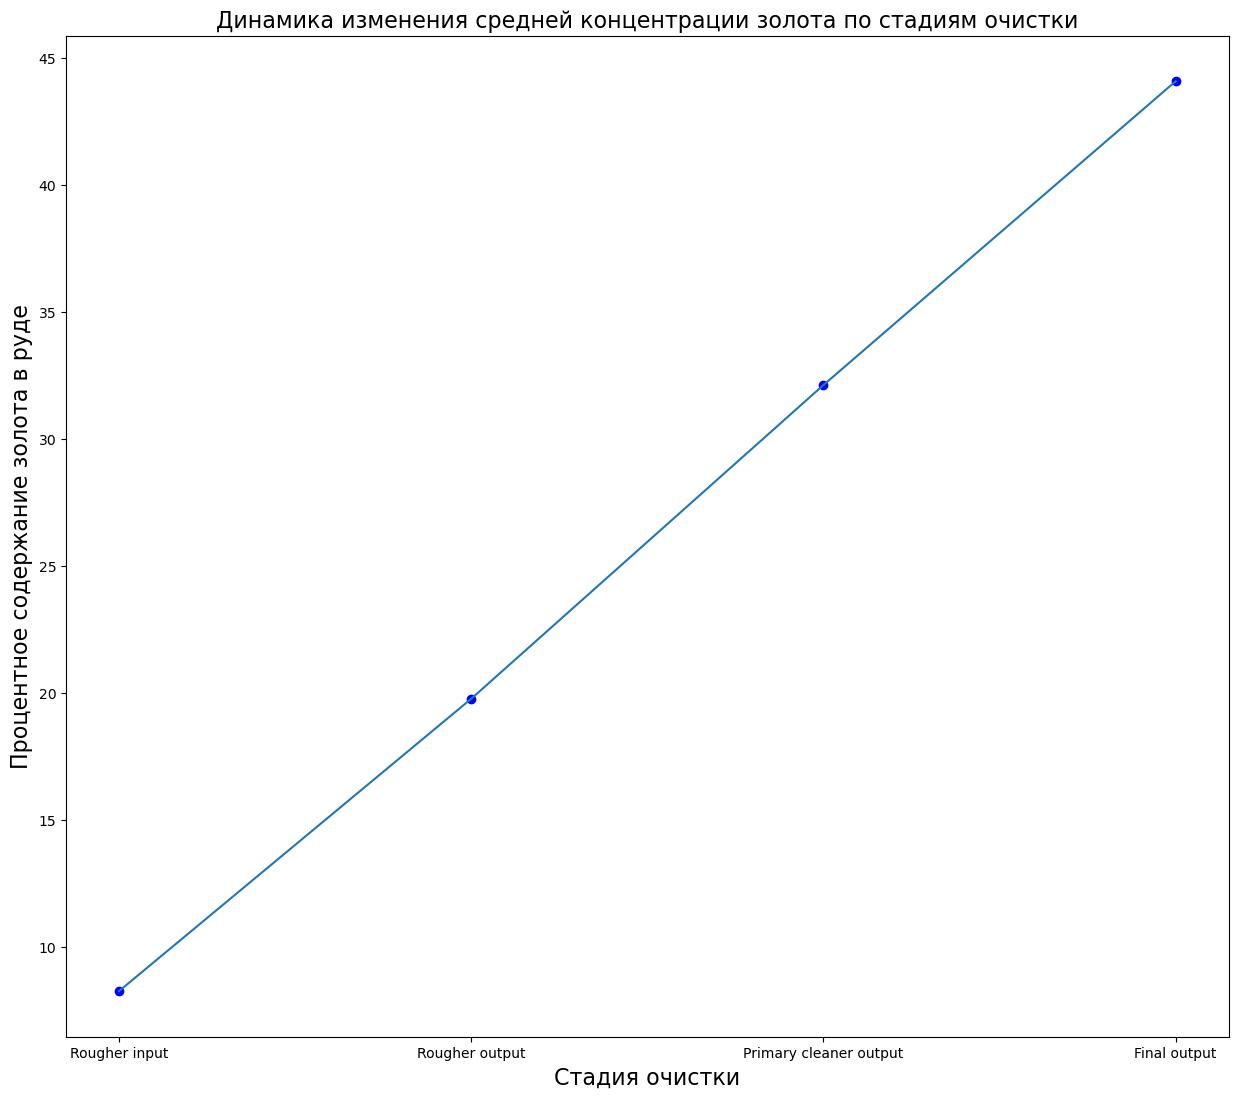

In [21]:
Au = [
    gold_industry_full['rougher.input.feed_au'].mean(), 
    gold_industry_full['rougher.output.concentrate_au'].mean(),
    gold_industry_full['primary_cleaner.output.concentrate_au'].mean(),
    gold_industry_full['final.output.concentrate_au'].mean()]
x = ['Rougher input', 'Rougher output', 'Primary cleaner output', 'Final output']
plt.plot(x, Au, 'ob')
plt.title('Динамика изменения средней концентрации золота по стадиям очистки', fontsize=16)
plt.xlabel('Стадия очистки',fontsize=16)
plt.ylabel('Процентное содержание золота в руде',fontsize=16)
plt.plot(Au)
plt.show()

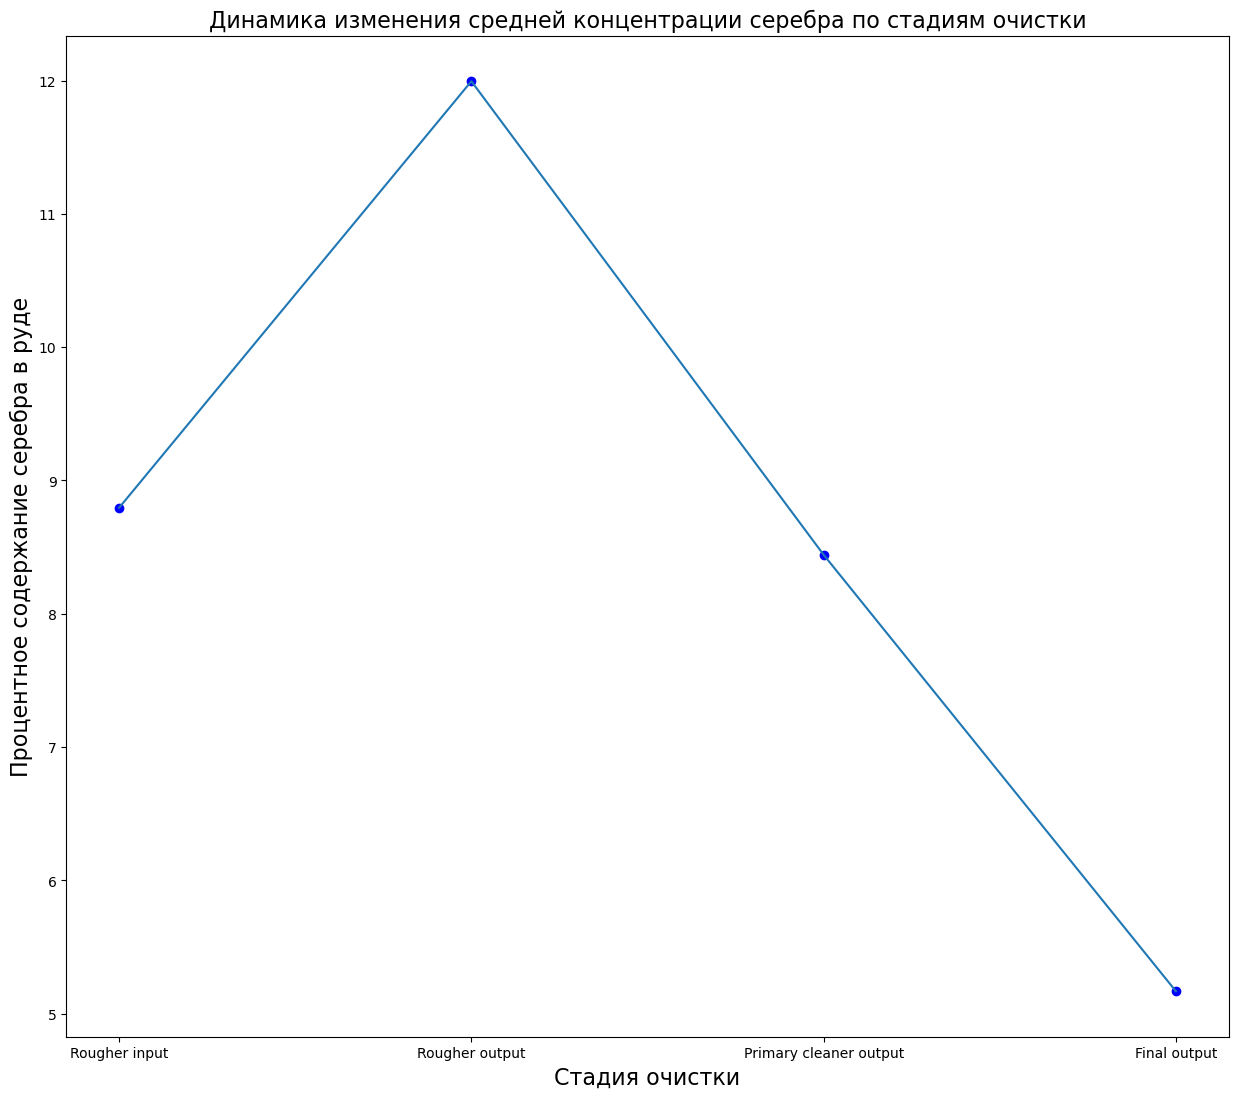

In [22]:
Ag = [
    gold_industry_full['rougher.input.feed_ag'].mean(), 
    gold_industry_full['rougher.output.concentrate_ag'].mean(),
    gold_industry_full['primary_cleaner.output.concentrate_ag'].mean(),
    gold_industry_full['final.output.concentrate_ag'].mean()]
x = ['Rougher input', 'Rougher output', 'Primary cleaner output', 'Final output']
plt.plot(x, Ag, 'ob')
plt.title('Динамика изменения средней концентрации серебра по стадиям очистки', fontsize=16)
plt.xlabel('Стадия очистки',fontsize=16)
plt.ylabel('Процентное содержание серебра в руде',fontsize=16)
plt.plot(Ag)
plt.show()

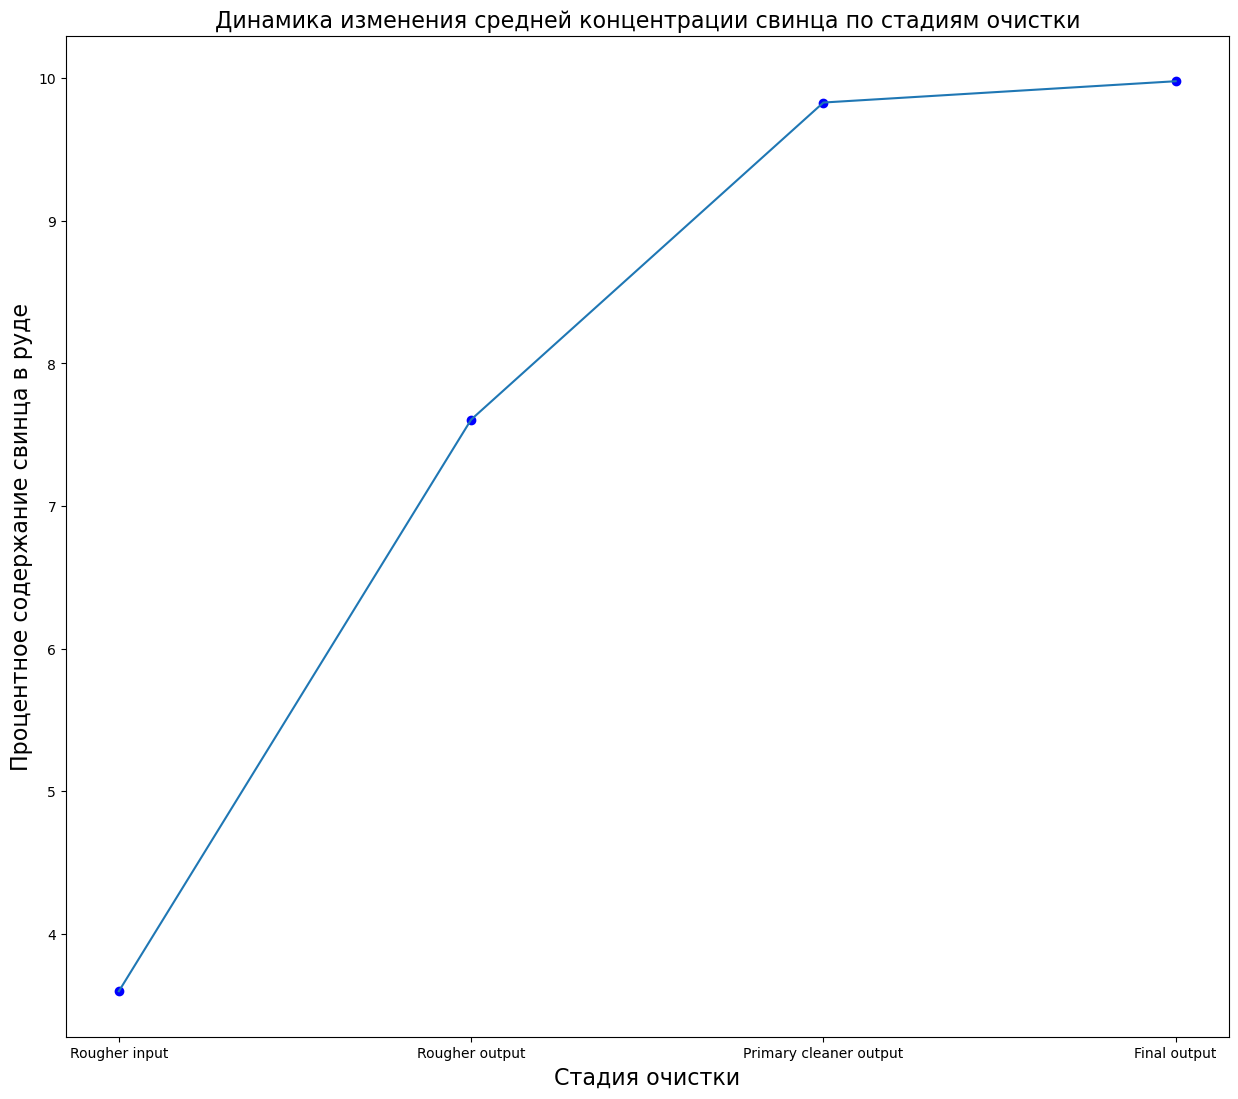

In [23]:
Pb = [
    gold_industry_full['rougher.input.feed_pb'].mean(), 
    gold_industry_full['rougher.output.concentrate_pb'].mean(),
    gold_industry_full['primary_cleaner.output.concentrate_pb'].mean(),
    gold_industry_full['final.output.concentrate_pb'].mean()]
x = ['Rougher input', 'Rougher output', 'Primary cleaner output', 'Final output']
plt.plot(x, Pb, 'ob')
plt.title('Динамика изменения средней концентрации свинца по стадиям очистки', fontsize=16)
plt.xlabel('Стадия очистки',fontsize=16)
plt.ylabel('Процентное содержание свинца в руде',fontsize=16)
plt.plot(Pb)
plt.show()

Из графиков видно, что доля свинца и золота возрастает в процессе всех очисток, а серебра наоборот - падает.

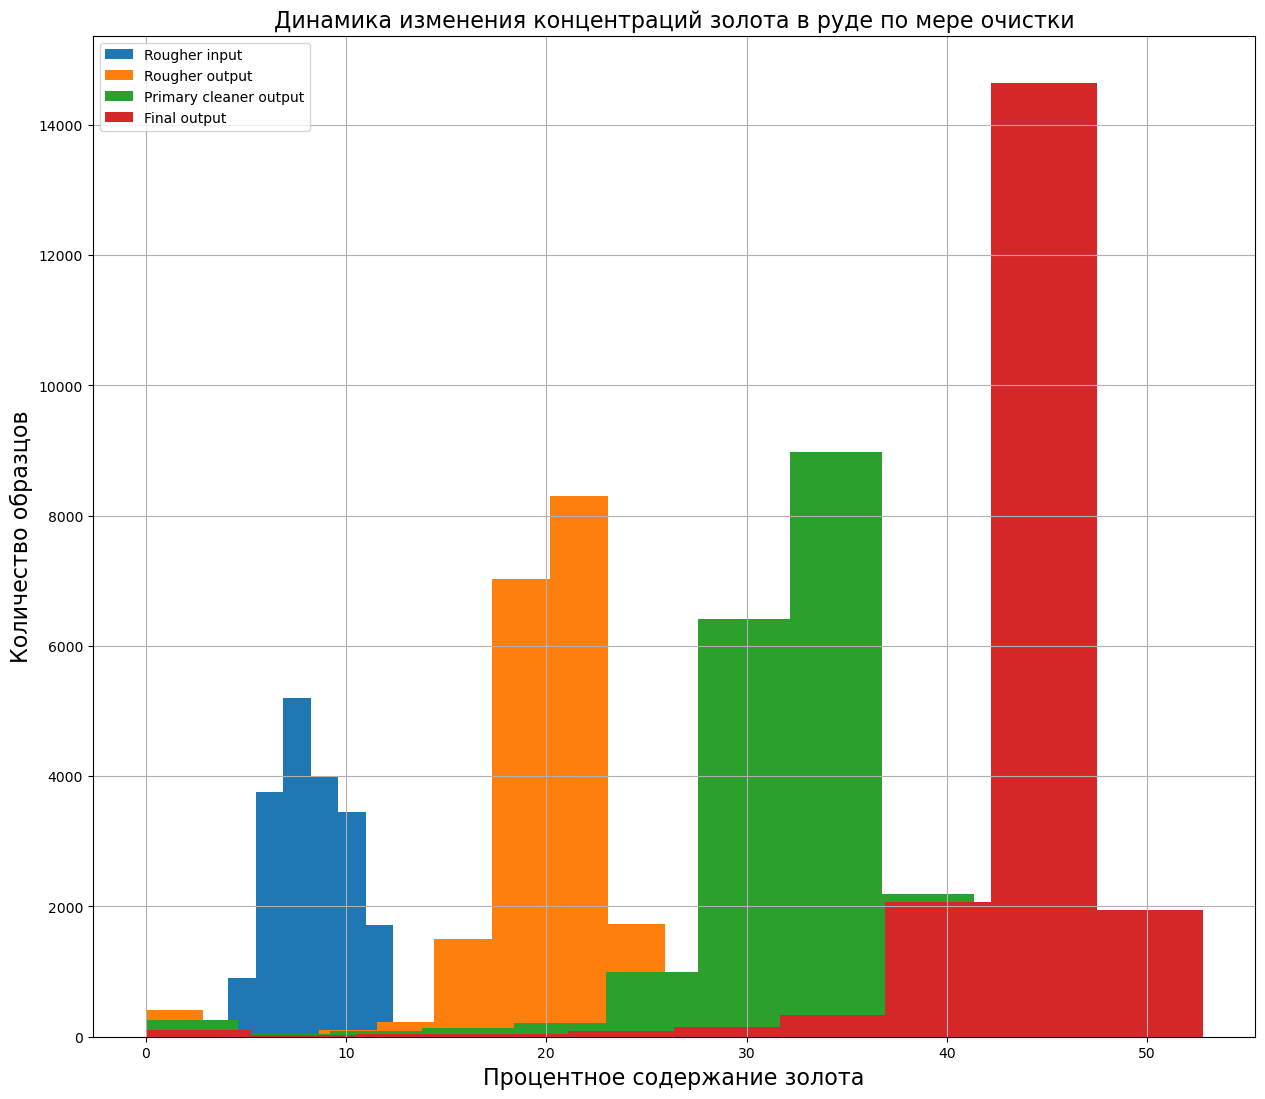

In [24]:
gold_industry_full['rougher.input.feed_au'].hist()
gold_industry_full['rougher.output.concentrate_au'].hist()
gold_industry_full['primary_cleaner.output.concentrate_au'].hist()
gold_industry_full['final.output.concentrate_au'].hist()
plt.title('Динамика изменения концентраций золота в руде по мере очистки',fontsize=16)
plt.legend(['Rougher input', 'Rougher output', 'Primary cleaner output', 'Final output'])
plt.xlabel('Процентное содержание золота',fontsize=16)
plt.ylabel('Количество образцов', fontsize=16)
plt.show()

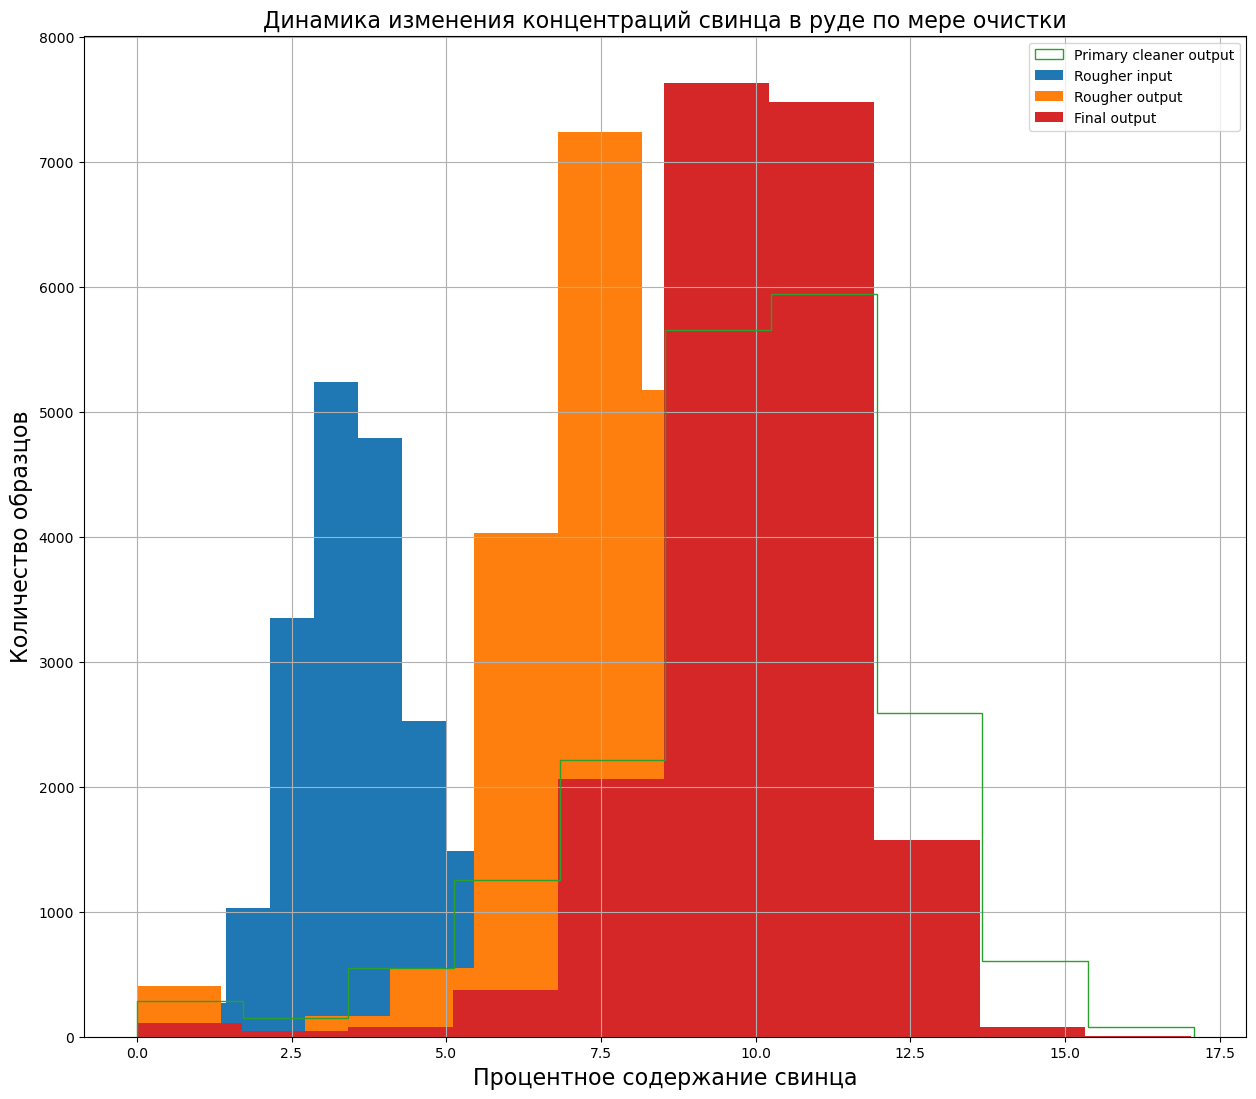

In [25]:
gold_industry_full['rougher.input.feed_pb'].hist()
gold_industry_full['rougher.output.concentrate_pb'].hist()
gold_industry_full['primary_cleaner.output.concentrate_pb'].hist(histtype='step')
gold_industry_full['final.output.concentrate_pb'].hist()
plt.title('Динамика изменения концентраций свинца в руде по мере очистки', fontsize=16)
plt.legend(['Primary cleaner output','Rougher input', 'Rougher output',  'Final output'])
plt.xlabel('Процентное содержание свинца',fontsize=16)
plt.ylabel('Количество образцов', fontsize=16)
plt.show()

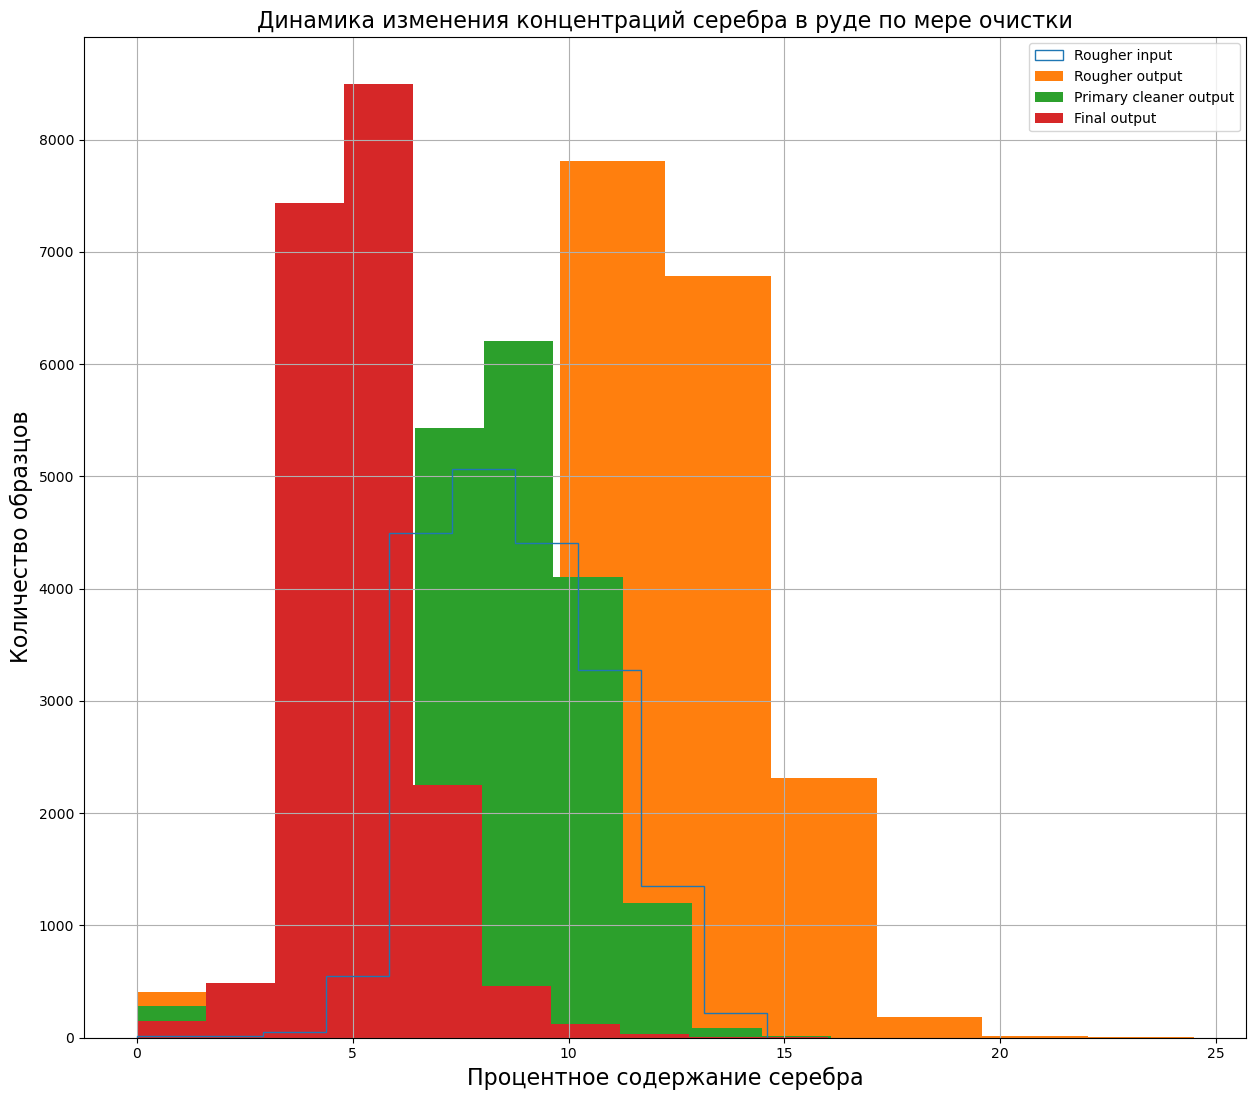

In [26]:
gold_industry_full['rougher.input.feed_ag'].hist(histtype='step')
gold_industry_full['rougher.output.concentrate_ag'].hist()
gold_industry_full['primary_cleaner.output.concentrate_ag'].hist()
gold_industry_full['final.output.concentrate_ag'].hist()
plt.title('Динамика изменения концентраций серебра в руде по мере очистки',fontsize=16)
plt.legend(['Rougher input', 'Rougher output', 'Primary cleaner output', 'Final output'])
plt.xlabel('Процентное содержание серебра',fontsize=16)
plt.ylabel('Количество образцов', fontsize=16)
plt.show()

Как видим из гистограмм, концентрации золота и свинца по мере прохождения стадий очистки увеличиваются. Причем, помимо увеличения, наблюдается и концентрация точек около определенных значений (многие образцы имеют примерно похожее содержание золота и свинца), то есть, очистка работает хорошо и во всех случаях получается примерно одна и та же концентрация этих металлов (кстати группировку значений около определенной величины можно наблюдать и в случае серебра). Для серебра, однако, концентрация постепенно снижается.

Видим, что распределение концентрации металлов в принципе похожи, но есть выбросы в районе нуля на трех из четырех этапах очистки. Такого быть не должно: ни на каком из этапов концентрация металлов не должна быть равна нулю. Поэтому следует удалить строки, где суммарная концентрации на этапе очистки равна нулю.

In [27]:
rougher_input_feed_sum = gold_industry_full['rougher.input.feed_au'] + gold_industry_full['rougher.input.feed_ag'] + gold_industry_full['rougher.input.feed_pb'] + gold_industry_full['rougher.input.feed_sol']
rougher_output_concentrate_sum = gold_industry_full['rougher.output.concentrate_au'] + gold_industry_full['rougher.output.concentrate_ag'] + gold_industry_full['rougher.output.concentrate_pb'] + gold_industry_full['rougher.output.concentrate_sol']
primary_cleaner_output_concentrate_sum = gold_industry_full['primary_cleaner.output.concentrate_au'] + gold_industry_full['primary_cleaner.output.concentrate_ag'] + gold_industry_full['primary_cleaner.output.concentrate_pb'] + gold_industry_full['primary_cleaner.output.concentrate_sol']
final_output_concentrate_sum = gold_industry_full['final.output.concentrate_au'] + gold_industry_full['final.output.concentrate_ag'] + gold_industry_full['final.output.concentrate_pb'] + gold_industry_full['final.output.concentrate_sol']

In [28]:
print(rougher_output_concentrate_sum[rougher_output_concentrate_sum == 0].index)
print()
print(primary_cleaner_output_concentrate_sum[primary_cleaner_output_concentrate_sum == 0].index)
print()
print(final_output_concentrate_sum[final_output_concentrate_sum == 0].index)

Int64Index([   36,    37,    38,    39,    40,    41,    42,   600,   984,
             1289,
            ...
            12113, 12114, 12131, 12132, 12133, 12134, 12135, 12136, 12137,
            12138],
           dtype='int64', length=394)

Int64Index([   14,    17,    25,    58,    61,    75,    76,    84,   592,
              593,
            ...
            11367, 11368, 11518, 11609, 11612, 11882, 11885, 11898, 11955,
            12059],
           dtype='int64', length=108)

Int64Index([  516,   943,   944,   945,   946,  1289,  1547,  1548,  1721,
             2598,  2599,  2600,  2601,  2604,  3276,  3354,  3554,  3621,
             3622,  3668,  3870,  4009,  4010,  4596,  4901,  5021,  5666,
             5667,  5668,  5861,  5862,  5863,  5864,  5865,  5999,  6000,
             6486,  6557,  6558,  6702,  6703,  6704,  6705,  6915,  7049,
             7509,  7510,  7511,  7512,  7513,  7779,  7877,  7878,  7908,
             8743,  8926,  8935,  8936,  8937,  8947,  8948,  

Как видим, индексы тех строк, в которых на этапах очистки суммарная концентрация металлов равна нулю, попадают в индексы только обучающей выборки (как мы помним, индексы тестовой выборки начинаются с 14579 строки). Поэтому, удалим из тестовой выборки строки с такими индексами.

In [29]:
indexes = list(rougher_output_concentrate_sum[rougher_output_concentrate_sum == 0].index) + list(primary_cleaner_output_concentrate_sum[primary_cleaner_output_concentrate_sum == 0].index) + list(final_output_concentrate_sum[final_output_concentrate_sum == 0].index)
indexes = list(pd.Series(indexes).unique())
gold_industry_full = gold_industry_full.drop(index=indexes)

In [30]:
new_gold_industry_train = new_gold_industry_train.drop(index=indexes)

In [31]:
rougher_input_feed_sum = gold_industry_full['rougher.input.feed_au'] + gold_industry_full['rougher.output.concentrate_ag'] + gold_industry_full['rougher.output.concentrate_pb'] + gold_industry_full['rougher.output.concentrate_sol']
rougher_output_concentrate_sum = gold_industry_full['rougher.output.concentrate_au'] + gold_industry_full['rougher.output.concentrate_ag'] + gold_industry_full['rougher.output.concentrate_pb'] + gold_industry_full['rougher.output.concentrate_sol']
primary_cleaner_output_concentrate_sum = gold_industry_full['primary_cleaner.output.concentrate_au'] + gold_industry_full['primary_cleaner.output.concentrate_ag'] + gold_industry_full['primary_cleaner.output.concentrate_pb'] + gold_industry_full['primary_cleaner.output.concentrate_sol']
final_output_concentrate_sum = gold_industry_full['final.output.concentrate_au'] + gold_industry_full['final.output.concentrate_ag'] + gold_industry_full['final.output.concentrate_pb'] + gold_industry_full['final.output.concentrate_sol']

In [32]:
indexes = list(rougher_output_concentrate_sum[rougher_output_concentrate_sum == 0].index) + list(primary_cleaner_output_concentrate_sum[primary_cleaner_output_concentrate_sum == 0].index) + list(final_output_concentrate_sum[final_output_concentrate_sum == 0].index)
indexes

[]

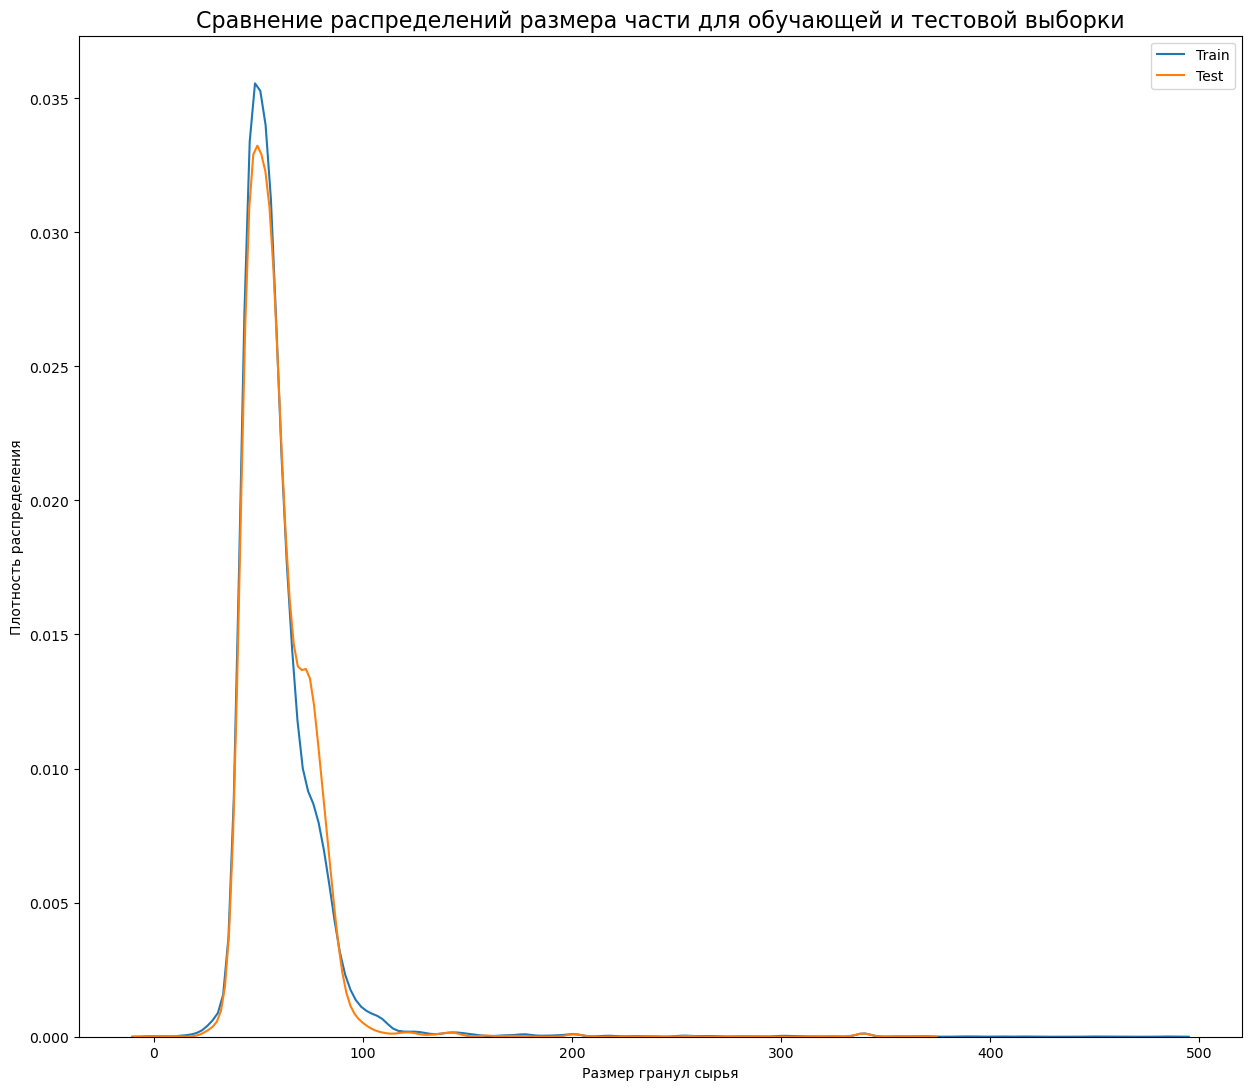

In [33]:
sns.kdeplot(new_gold_industry_train['rougher.input.feed_size'])
sns.kdeplot(new_gold_industry_test['rougher.input.feed_size'])
plt.title('Сравнение распределений размера части для обучающей и тестовой выборки', fontsize=16)
plt.xlabel('Размер гранул сырья')
plt.ylabel('Плотность распределения')
plt.legend(['Train', 'Test'])
plt.show()

Распределение данных по размерам гранул исходного сырья напоминает распределение Пуассона и в принципе можно сказать, что они совпадают.

Теперь найдем суммарные концентрации металлов на разных стадиях очистки.

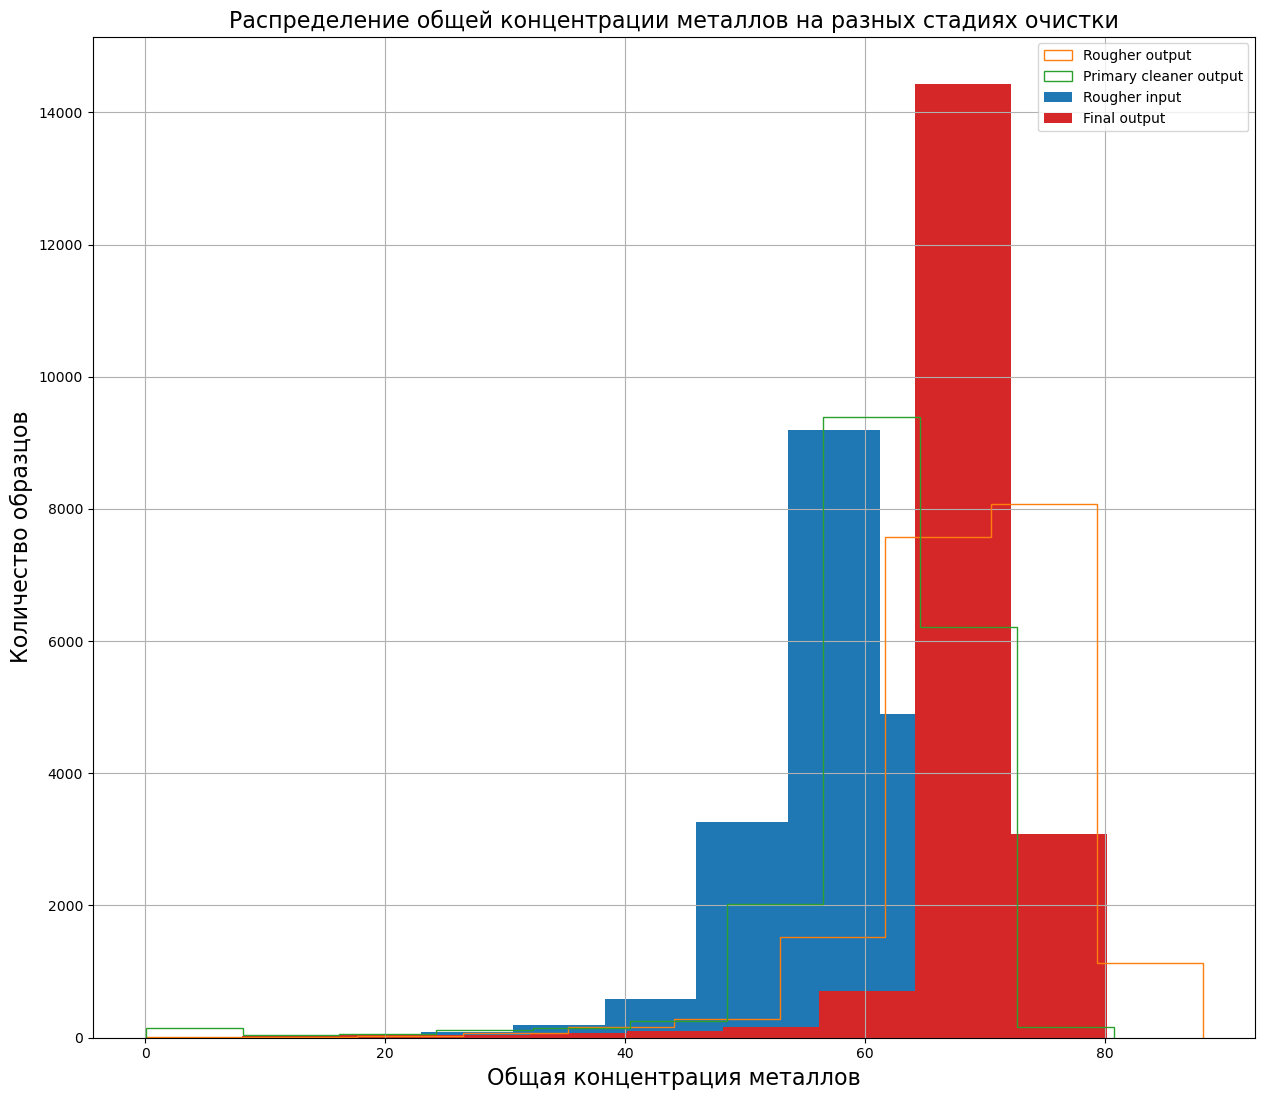

In [34]:
rougher_input_feed_sum.hist()
plt.title('Распределение общей концентрации металлов на разных стадиях очистки',fontsize=16)
rougher_output_concentrate_sum.hist(histtype='step')
primary_cleaner_output_concentrate_sum.hist(histtype='step')
final_output_concentrate_sum.hist()
plt.xlabel('Общая концентрация металлов',fontsize=16)
plt.ylabel('Количество образцов', fontsize=16)
plt.legend(['Rougher output', 'Primary cleaner output', 'Rougher input', 'Final output'])
plt.show()

По мере прохождения стадий очистки, данные группируются около вполне определенного значения суммарной концентрации металлов. Опять же, как я думаю, это говорит о том, что очистка работает хорошо и на выходе каждый раз получается продукт, с примерно одинаковым содержанием металлов в нем.

ВЫВОДЫ ПО БЛОКУ:

- Проведено исследование изменений концентраций металлов (золота, свинца и серебра) на стадиях очистки.
- Выяснено, что в конечном продукте концентрации металлов группируются около определенного значения, что может говорить об однородности образцов по содержанию металлов после всех стадий очистки.
- Показано, что концентрации золота и свинца по мере очистки увеличиваются, а концентрация серебра, напротив, уменьшается.
- Продемонстрировано с помощью графика, что распределения размеров частиц на обучающей и тестовой выборке совпадают.
- Выявлены и удалены аномальные значения (общая концентрация металлов на разных стадиях очистки нулевая).

## Модель

Теперь отмасштабируем признаки.

In [35]:
numeric = list(new_gold_industry_train.columns)
len(numeric)

55

In [36]:
numeric = numeric[1:53]
numeric

['rougher.input.feed_au',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_sol',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_d_air',
 'rougher.state.floatbank10_d_level',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_e_level',
 'rougher.state.floatbank10_f_air',
 'rougher.state.floatbank10_f_level',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_c

In [37]:
scaler = StandardScaler()
scaler.fit(new_gold_industry_train[numeric])
new_gold_industry_train[numeric] = scaler.transform(new_gold_industry_train[numeric])
new_gold_industry_test[numeric] = scaler.transform(new_gold_industry_test[numeric])

Напишем функцию sMAPE.

In [38]:
def sMAPE(target, predictions):
    return (200*(((abs(predictions-target))/(abs(predictions)+abs(target))).sum()))/len(target)

def full_sMAPE(sMAPE_rougher, sMAPE_final):
    return (0.25*sMAPE_rougher + 0.75*sMAPE_final)

In [39]:
rougher_features = new_gold_industry_train.loc[:, 'rougher.input.feed_au':'rougher.input.floatbank11_xanthate']
rougher_target = new_gold_industry_train['rougher.output.recovery']
final_features = new_gold_industry_train.loc[:, 'rougher.input.feed_au':'secondary_cleaner.state.floatbank6_a_level']
final_target = new_gold_industry_train['final.output.recovery']

rougher_features_test = new_gold_industry_test.loc[:, 'rougher.input.feed_au':'rougher.input.floatbank11_xanthate']
rougher_target_test = new_gold_industry_test['rougher.output.recovery']
final_features_test = new_gold_industry_test.loc[:, 'rougher.input.feed_au':'secondary_cleaner.state.floatbank6_a_level']
final_target_test = new_gold_industry_test['final.output.recovery']

In [40]:
sMAPE_scor = make_scorer(sMAPE, greater_is_better=False)

Будем обучать и проверять три модели регрессии: линейную регрессию, решающее дерево и случайный лес. Подберем гиперпараметры с помощью GridSearchCV.

In [41]:
model_1 = LinearRegression()
model_2 =  DecisionTreeRegressor(random_state=12345)
model_3 = RandomForestRegressor(random_state=12345)

In [42]:
parameters_linear_regression = {}
grid_search_model_1 = GridSearchCV(model_1, parameters_linear_regression, cv=3, scoring=sMAPE_scor)
grid_search_model_1.fit(rougher_features, rougher_target)
print('Лучшая sMAPE: ', -grid_search_model_1.best_score_)
sMAPE_rougher_model_1 = -grid_search_model_1.best_score_

Лучшая sMAPE:  7.475387129868871


In [43]:
grid_search_model_1.fit(final_features, final_target)
print('Лучшие гиперпараметры: ', grid_search_model_1.best_params_)
print('Лучшая sMAPE: ', -grid_search_model_1.best_score_)
sMAPE_final_model_1 = -grid_search_model_1.best_score_

Лучшие гиперпараметры:  {}
Лучшая sMAPE:  11.209645296376067


In [44]:
print(f'Лучшая sMAPE для линейной регрессии: {full_sMAPE(sMAPE_rougher_model_1, sMAPE_final_model_1)}')

Лучшая sMAPE для линейной регрессии: 10.276080754749268


Теперь дерево решений.

In [45]:
parameters_decision_tree = { 'max_depth': range(1,6),
                            'min_samples_leaf': range(1,21,2),
                            'min_samples_split': range(2,21,2)}
grid_search_model_2 = GridSearchCV(model_2,parameters_decision_tree,cv=3,scoring=sMAPE_scor, n_jobs=-1, verbose=10)
grid_search_model_2.fit(rougher_features, rougher_target)
print('Лучшие гиперпараметры: ', grid_search_model_2.best_params_)
print('Лучшая sMAPE: ', -grid_search_model_2.best_score_)
sMAPE_rougher_model_2 = -grid_search_model_2.best_score_

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[CV 1/3; 1/500] START max_depth=1, min_samples_leaf=1, min_samples_split=2......
[CV 1/3; 1/500] END max_depth=1, min_samples_leaf=1, min_samples_split=2;, score=-9.055 total time=   0.0s
[CV 2/3; 2/500] START max_depth=1, min_samples_leaf=1, min_samples_split=4......
[CV 2/3; 2/500] END max_depth=1, min_samples_leaf=1, min_samples_split=4;, score=-7.239 total time=   0.0s
[CV 3/3; 3/500] START max_depth=1, min_samples_leaf=1, min_samples_split=6......
[CV 3/3; 3/500] END max_depth=1, min_samples_leaf=1, min_samples_split=6;, score=-8.376 total time=   0.0s
[CV 1/3; 5/500] START max_depth=1, min_samples_leaf=1, min_samples_split=10.....
[CV 1/3; 5/500] END max_depth=1, min_samples_leaf=1, min_samples_split=10;, score=-9.055 total time=   0.0s
[CV 2/3; 6/500] START max_depth=1, min_samples_leaf=1, min_samples_split=12.....
[CV 2/3; 6/500] END max_depth=1, min_samples_leaf=1, min_samples_split=12;, score=-7.239 total time=  

In [46]:
grid_search_model_2.fit(final_features, final_target)
print('Лучшие гиперпараметры: ', grid_search_model_2.best_params_)
print('Лучшая sMAPE: ', -grid_search_model_2.best_score_)
sMAPE_final_model_2 = -grid_search_model_2.best_score_

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[CV 2/3; 342/500] START max_depth=4, min_samples_leaf=9, min_samples_split=4....
[CV 2/3; 342/500] END max_depth=4, min_samples_leaf=9, min_samples_split=4;, score=-6.116 total time=   0.1s
[CV 3/3; 342/500] START max_depth=4, min_samples_leaf=9, min_samples_split=4....
[CV 3/3; 342/500] END max_depth=4, min_samples_leaf=9, min_samples_split=4;, score=-6.537 total time=   0.1s
[CV 1/3; 343/500] START max_depth=4, min_samples_leaf=9, min_samples_split=6....
[CV 1/3; 343/500] END max_depth=4, min_samples_leaf=9, min_samples_split=6;, score=-8.232 total time=   0.1s
[CV 2/3; 343/500] START max_depth=4, min_samples_leaf=9, min_samples_split=6....
[CV 2/3; 343/500] END max_depth=4, min_samples_leaf=9, min_samples_split=6;, score=-6.116 total time=   0.1s
[CV 3/3; 351/500] START max_depth=4, min_samples_leaf=11, min_samples_split=2...
[CV 3/3; 351/500] END max_depth=4, min_samples_leaf=11, min_samples_split=2;, score=-6.530 tota

In [47]:
print(f'Лучшая sMAPE для решающего дерева: {full_sMAPE(sMAPE_rougher_model_2, sMAPE_final_model_2)}')

Лучшая sMAPE для решающего дерева: 8.948872806725092


Перейдем к случайному лесу.

In [48]:
parameters_random_forest = {'n_estimators': range(10, 101, 10), 'max_depth': range(1,11)}
grid_search_model_3 = GridSearchCV(model_3,parameters_random_forest,cv=3, scoring=sMAPE_scor, n_jobs=-1, verbose=10)
grid_search_model_3.fit(rougher_features, rougher_target)
print('Лучшие гиперпараметры: ', grid_search_model_3.best_params_)
print('Лучшая sMAPE: ', -grid_search_model_3.best_score_)
sMAPE_rougher_model_3 = -grid_search_model_3.best_score_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 3/3; 405/500] END max_depth=5, min_samples_leaf=1, min_samples_split=10;, score=-14.349 total time=   0.2s
[CV 1/3; 406/500] START max_depth=5, min_samples_leaf=1, min_samples_split=12...
[CV 1/3; 406/500] END max_depth=5, min_samples_leaf=1, min_samples_split=12;, score=-9.227 total time=   0.2s
[CV 2/3; 408/500] START max_depth=5, min_samples_leaf=1, min_samples_split=16...
[CV 2/3; 408/500] END max_depth=5, min_samples_leaf=1, min_samples_split=16;, score=-9.680 total time=   0.2s
[CV 3/3; 408/500] START max_depth=5, min_samples_leaf=1, min_samples_split=16...
[CV 3/3; 408/500] END max_depth=5, min_samples_leaf=1, min_samples_split=16;, score=-14.349 total time=   0.2s
[CV 1/3; 411/500] START max_depth=5, min_samples_leaf=3, min_samples_split=2....
[CV 1/3; 411/500] END max_depth=5, min_samples_leaf=3, min_samples_split=2;, score=-9.230 total time=   0.3s
[CV 2/3; 411/500] START max_depth=5, min_samples_leaf=3, min_s

In [49]:
grid_search_model_3.fit(final_features, final_target)
print('Лучшие гиперпараметры: ', grid_search_model_3.best_params_)
print('Лучшая sMAPE: ', -grid_search_model_3.best_score_)
sMAPE_final_model_3 = -grid_search_model_3.best_score_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3; 413/500] END max_depth=5, min_samples_leaf=3, min_samples_split=6;, score=-9.230 total time=   0.2s
[CV 2/3; 413/500] START max_depth=5, min_samples_leaf=3, min_samples_split=6....
[CV 2/3; 413/500] END max_depth=5, min_samples_leaf=3, min_samples_split=6;, score=-9.708 total time=   0.2s
[CV 3/3; 415/500] START max_depth=5, min_samples_leaf=3, min_samples_split=10...
[CV 3/3; 415/500] END max_depth=5, min_samples_leaf=3, min_samples_split=10;, score=-13.446 total time=   0.3s
[CV 1/3; 416/500] START max_depth=5, min_samples_leaf=3, min_samples_split=12...
[CV 1/3; 416/500] END max_depth=5, min_samples_leaf=3, min_samples_split=12;, score=-9.230 total time=   0.3s
[CV 2/3; 418/500] START max_depth=5, min_samples_leaf=3, min_samples_split=16...
[CV 2/3; 418/500] END max_depth=5, min_samples_leaf=3, min_samples_split=16;, score=-9.704 total time=   0.2s
[CV 3/3; 418/500] START max_depth=5, min_samples_leaf=3, min_sam

In [50]:
print(f'Лучшая sMAPE для случайного леса: {full_sMAPE(sMAPE_rougher_model_3, sMAPE_final_model_3)}')

Лучшая sMAPE для случайного леса: 8.693878774839513


После проведенного исследования лучшей оказалась модель случайного леса

In [53]:
model = RandomForestRegressor(random_state=12345, max_depth=4, n_estimators=70)
model.fit(rougher_features, rougher_target)
rougher_model_predictions = model.predict(rougher_features_test)
sMAPE_rougher_model = sMAPE(rougher_target_test, rougher_model_predictions)
model = RandomForestRegressor(random_state=12345, max_depth=2, n_estimators=60)
model.fit(final_features, final_target)
final_model_predictions = model.predict(final_features_test)
sMAPE_final_model = sMAPE(final_target_test, final_model_predictions)
print(f'Финальная sMAPE лучшей модели: {full_sMAPE(sMAPE_rougher_model, sMAPE_final_model)}')

Финальная sMAPE лучшей модели: 7.396615469034773


In [52]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(rougher_features, rougher_target)
rougher_predictions_dummy = dummy_regr.predict(rougher_features_test)
sMAPE_rougher_dummy = sMAPE(rougher_target_test, rougher_predictions_dummy)
dummy_regr.fit(final_features, final_target)
final_predictions_dummy = dummy_regr.predict(final_features_test)
sMAPE_final_dummy = sMAPE(final_target_test, final_predictions_dummy)
print(f'Финальная sMAPE константной модели: {full_sMAPE(sMAPE_rougher_dummy, sMAPE_final_dummy)}')

Финальная sMAPE константной модели: 8.472648251321258


## Общий вывод

Итак, в ходе работы над проектом удалось сделать следующие выводы:

- При первичной обработке выяснено, что данные достаточно хорошего качества: пропусков совсем немного, а явные дубликаты отсутствуют.
- При анализе данных показано, что система очистки руды работает вполне четко и для разных образцов конечный результат примерно одинаков. Также показано, что имели место аномалии: суммарная концентрация металлов на разных стадиях очистки равна нулю. Аномалии устранены.
- Исследовано три модели машинного обучения: линейная регрессия, решающее дерево и случайный лес. Осуществлен подбор лучших гиперпараметров и первичная оценка с помощью кросс-валидации.
- По результатам исследования лучшей признана модель случайного леса с метрикой (sMAPE) = 8.6939.
- При сравнении с константной моделью показано, что найденная модель превосходит ее по метрике sMAPE (7.3966 у нашей модели против 8.473 у константной). 